# Overview
**Goal:** We want to predict how long a diabetes patient will stay in the hospital. <br/>

**Dataset Stats:** 101766 rows with 47 features and 1 target feature. <br/>

**Features Used:** race, gender, age, num_procedures, num_medications, num_diagnoses, number_emergency, diabetesMed, readmitted<br/>

**Summary:** We chose the 9 best features that we believed would best predict how long a diabetes patient will stay in the hospital and dropped unnecessary features or features that had too many missing values (such as weight and medical_specialty). Then, we cleaned up missing values, encoded our data, plotted it, split it, and validated it. <br/>

**Dataset:**
https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008 <br/>

**Citations:** <br/>
Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.

**Members:** Lorentz Tuazon, Shijun Lun, Javier De La Cruz Zuniga, Rocky Hankin, Kane Li, Wesley Kiang, Su Aye, Asher James



In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [ ]:
#dependencies
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# Data Cleaning
Extract our the features we want to use and handle NaN, Null, and other missing values

In [ ]:
#load the features we want to use and target as X's and y's
features = diabetes_130_us_hospitals_for_years_1999_2008.data.features

#Since we use readmitted as a feature, which is the original targets, we have to join it to features
readmissions = diabetes_130_us_hospitals_for_years_1999_2008.data.targets
diabetes_ds = pd.concat([features, readmissions], axis=1)

#grab our relevant features
key_features = ['race', 'gender', 'age', 'num_procedures', 'num_medications', 'number_emergency', 'number_diagnoses', 'diabetesMed', 'readmitted', 'time_in_hospital']
data = diabetes_ds[key_features]

# our model's goal is to predict time in hospital
y = diabetes_ds[['time_in_hospital']]

# If you want to see X or y
data.head(5)
#y.head(10)

,race,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted,time_in_hospital
0,Caucasian,Female,[0-10),0,1,0,1,No,NO,1
1,Caucasian,Female,[10-20),0,18,0,9,Yes,>30,3
2,AfricanAmerican,Female,[20-30),5,13,0,6,Yes,NO,2
3,Caucasian,Male,[30-40),1,16,0,7,Yes,NO,2
4,Caucasian,Male,[40-50),0,8,0,5,Yes,NO,1


In [ ]:
#see where the NaN/null values are (y has no NaN)
data.isna().sum()
#y.isna().sum()

race                2273
gender                 0
age                    0
num_procedures         0
num_medications        0
number_emergency       0
number_diagnoses       0
diabetesMed            0
readmitted             0
time_in_hospital       0
dtype: int64

In [ ]:
#drop Null race values
data = data.dropna(axis=0)
data.isna().sum()

race                0
gender              0
age                 0
num_procedures      0
num_medications     0
number_emergency    0
number_diagnoses    0
diabetesMed         0
readmitted          0
time_in_hospital    0
dtype: int64

# Encoding
Race: One-hot-encoding.

Gender: Convert to binary. 1 for Male, 0 for Female.

Age: Convert to the middle of the range. Ex. 10-20 becomes 15

Diabetes_med: Convert to binary. 1 for yes, 0 for no.

Readmitted: A column for <30, and >30, and not readmitted. Direct numerical
progression, so we can do label encoding. 0, 1, 2.

In [ ]:
#one-hot-encode race
race_ohe = pd.get_dummies(data['race'], prefix='race')
data = data.drop('race', axis=1)
data = pd.concat([race_ohe, data], axis=1)

In [ ]:
#gender convert to binary
for index, value in data['gender'].items():
    if value == 'Male':
        data.at[index, 'gender'] = 1
    elif value == 'Female':
        data.at[index, 'gender'] = 0

In [ ]:
#age convert to middle of range
for index, value in data['age'].items():
    lower, higher = value.split('-')
    lower = int(lower[1:])
    higher = int(higher[:-1])
    middle = (lower + higher) // 2
    data.at[index, 'age'] = middle

In [ ]:
#diabetes med convert to binary
for index, value in data['diabetesMed'].items():
    if value == 'No':
        data.at[index, 'diabetesMed'] = int(0)
    elif value == 'Yes':
        data.at[index, 'diabetesMed'] = int(1)

In [ ]:
#label encode readmitted
for index, value in data['readmitted'].items():
    if value == 'NO':
        data.at[index, 'readmitted'] = int(2)
    elif value == '>30':
        data.at[index, 'readmitted'] = int(1)
    elif value == '<30':
        data.at[index, 'readmitted'] = int(0)

In [ ]:
#Verify encoding
data.head(10)

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted,time_in_hospital
0,0,0,1,0,0,0,5,0,1,0,1,0,2,1
1,0,0,1,0,0,0,15,0,18,0,9,1,1,3
2,1,0,0,0,0,0,25,5,13,0,6,1,2,2
3,0,0,1,0,0,1,35,1,16,0,7,1,2,2
4,0,0,1,0,0,1,45,0,8,0,5,1,2,1
5,0,0,1,0,0,1,55,6,16,0,9,1,1,3
6,0,0,1,0,0,1,65,1,21,0,7,1,2,4
7,0,0,1,0,0,1,75,0,12,0,8,1,1,5
8,0,0,1,0,0,0,85,2,28,0,8,1,2,13
9,0,0,1,0,0,0,95,3,18,0,8,1,2,12


# Normalize and Standardize Data
To improve training stability and performance, we use MinMaxScaling to normalize age, num_procedures, num_medications, number__emergency, and number_diagnoses. Then, we use StandardScaler to standardize all the data to a normal distribution.

In [ ]:
#normalize input data
from sklearn.preprocessing import minmax_scale

#Only normalize cols whose values vary a lot
scaleCols = ['age', 'num_procedures', 'num_medications', 'number_emergency', 'number_diagnoses']
data[scaleCols] = minmax_scale(data[scaleCols])
data.head(5)

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted,time_in_hospital
0,0,0,1,0,0,0,0.000000,0.000000,0.0000,0.0,0.000000,0,2,1
1,0,0,1,0,0,0,0.111111,0.000000,0.2125,0.0,0.533333,1,1,3
2,1,0,0,0,0,0,0.222222,0.833333,0.1500,0.0,0.333333,1,2,2
3,0,0,1,0,0,1,0.333333,0.166667,0.1875,0.0,0.400000,1,2,2
4,0,0,1,0,0,1,0.444444,0.000000,0.0875,0.0,0.266667,1,2,1


In [ ]:
#standardize the relevant columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[scaleCols])
data[scaleCols] = scaler.transform(data[scaleCols])
data.head(5)

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender,age,num_procedures,num_medications,number_emergency,number_diagnoses,diabetesMed,readmitted,time_in_hospital
0,0,0,1,0,0,0,-3.823191,-0.786858,-1.850624,-0.214199,-3.343217,0,2,1
1,0,0,1,0,0,0,-3.195979,-0.786858,0.243036,-0.214199,0.810353,1,1,3
2,1,0,0,0,0,0,-2.568767,2.147917,-0.372746,-0.214199,-0.747236,1,2,2
3,0,0,1,0,0,1,-1.941555,-0.199903,-0.003277,-0.214199,-0.228040,1,2,2
4,0,0,1,0,0,1,-1.314344,-0.786858,-0.988529,-0.214199,-1.266432,1,2,1


In [ ]:
data.isna().sum()

race_AfricanAmerican    0
race_Asian              0
race_Caucasian          0
race_Hispanic           0
race_Other              0
gender                  0
age                     0
num_procedures          0
num_medications         0
number_emergency        0
number_diagnoses        0
diabetesMed             0
readmitted              0
time_in_hospital        0
dtype: int64

# Visualization

<ipython-input-103-2c9fd113f724>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), fmt = '.1g', annot = True, cbar=False)


<Axes: >

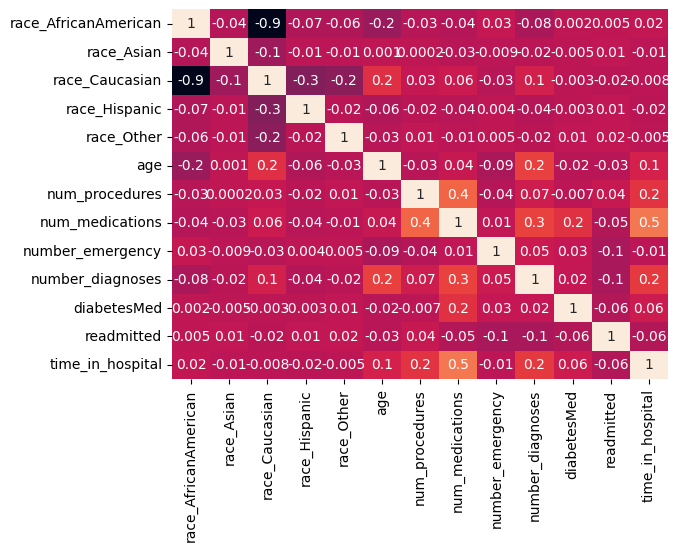

In [ ]:
# visualizing data via correlation matrix (heatmap) and pair plot
# make sure everything's numerical
data = data.convert_dtypes(convert_string=False)

#we'll include our target data in our plot
sns.heatmap(data.corr(), fmt = '.1g', annot = True, cbar=False)

Observations from the heatmap:

1.   Most features aren't very correlated with each other
2.   The correlation between racial categories varies even though they're equally mutually exclusive
3.   By far the feature most correlated with the duration of the hospital stay is how many medications they're on.
4.   When we build our model to predict time in hospital, we should drop race, number of emergencies, readmission, and whether they're on medication as these have low correlation with the target.

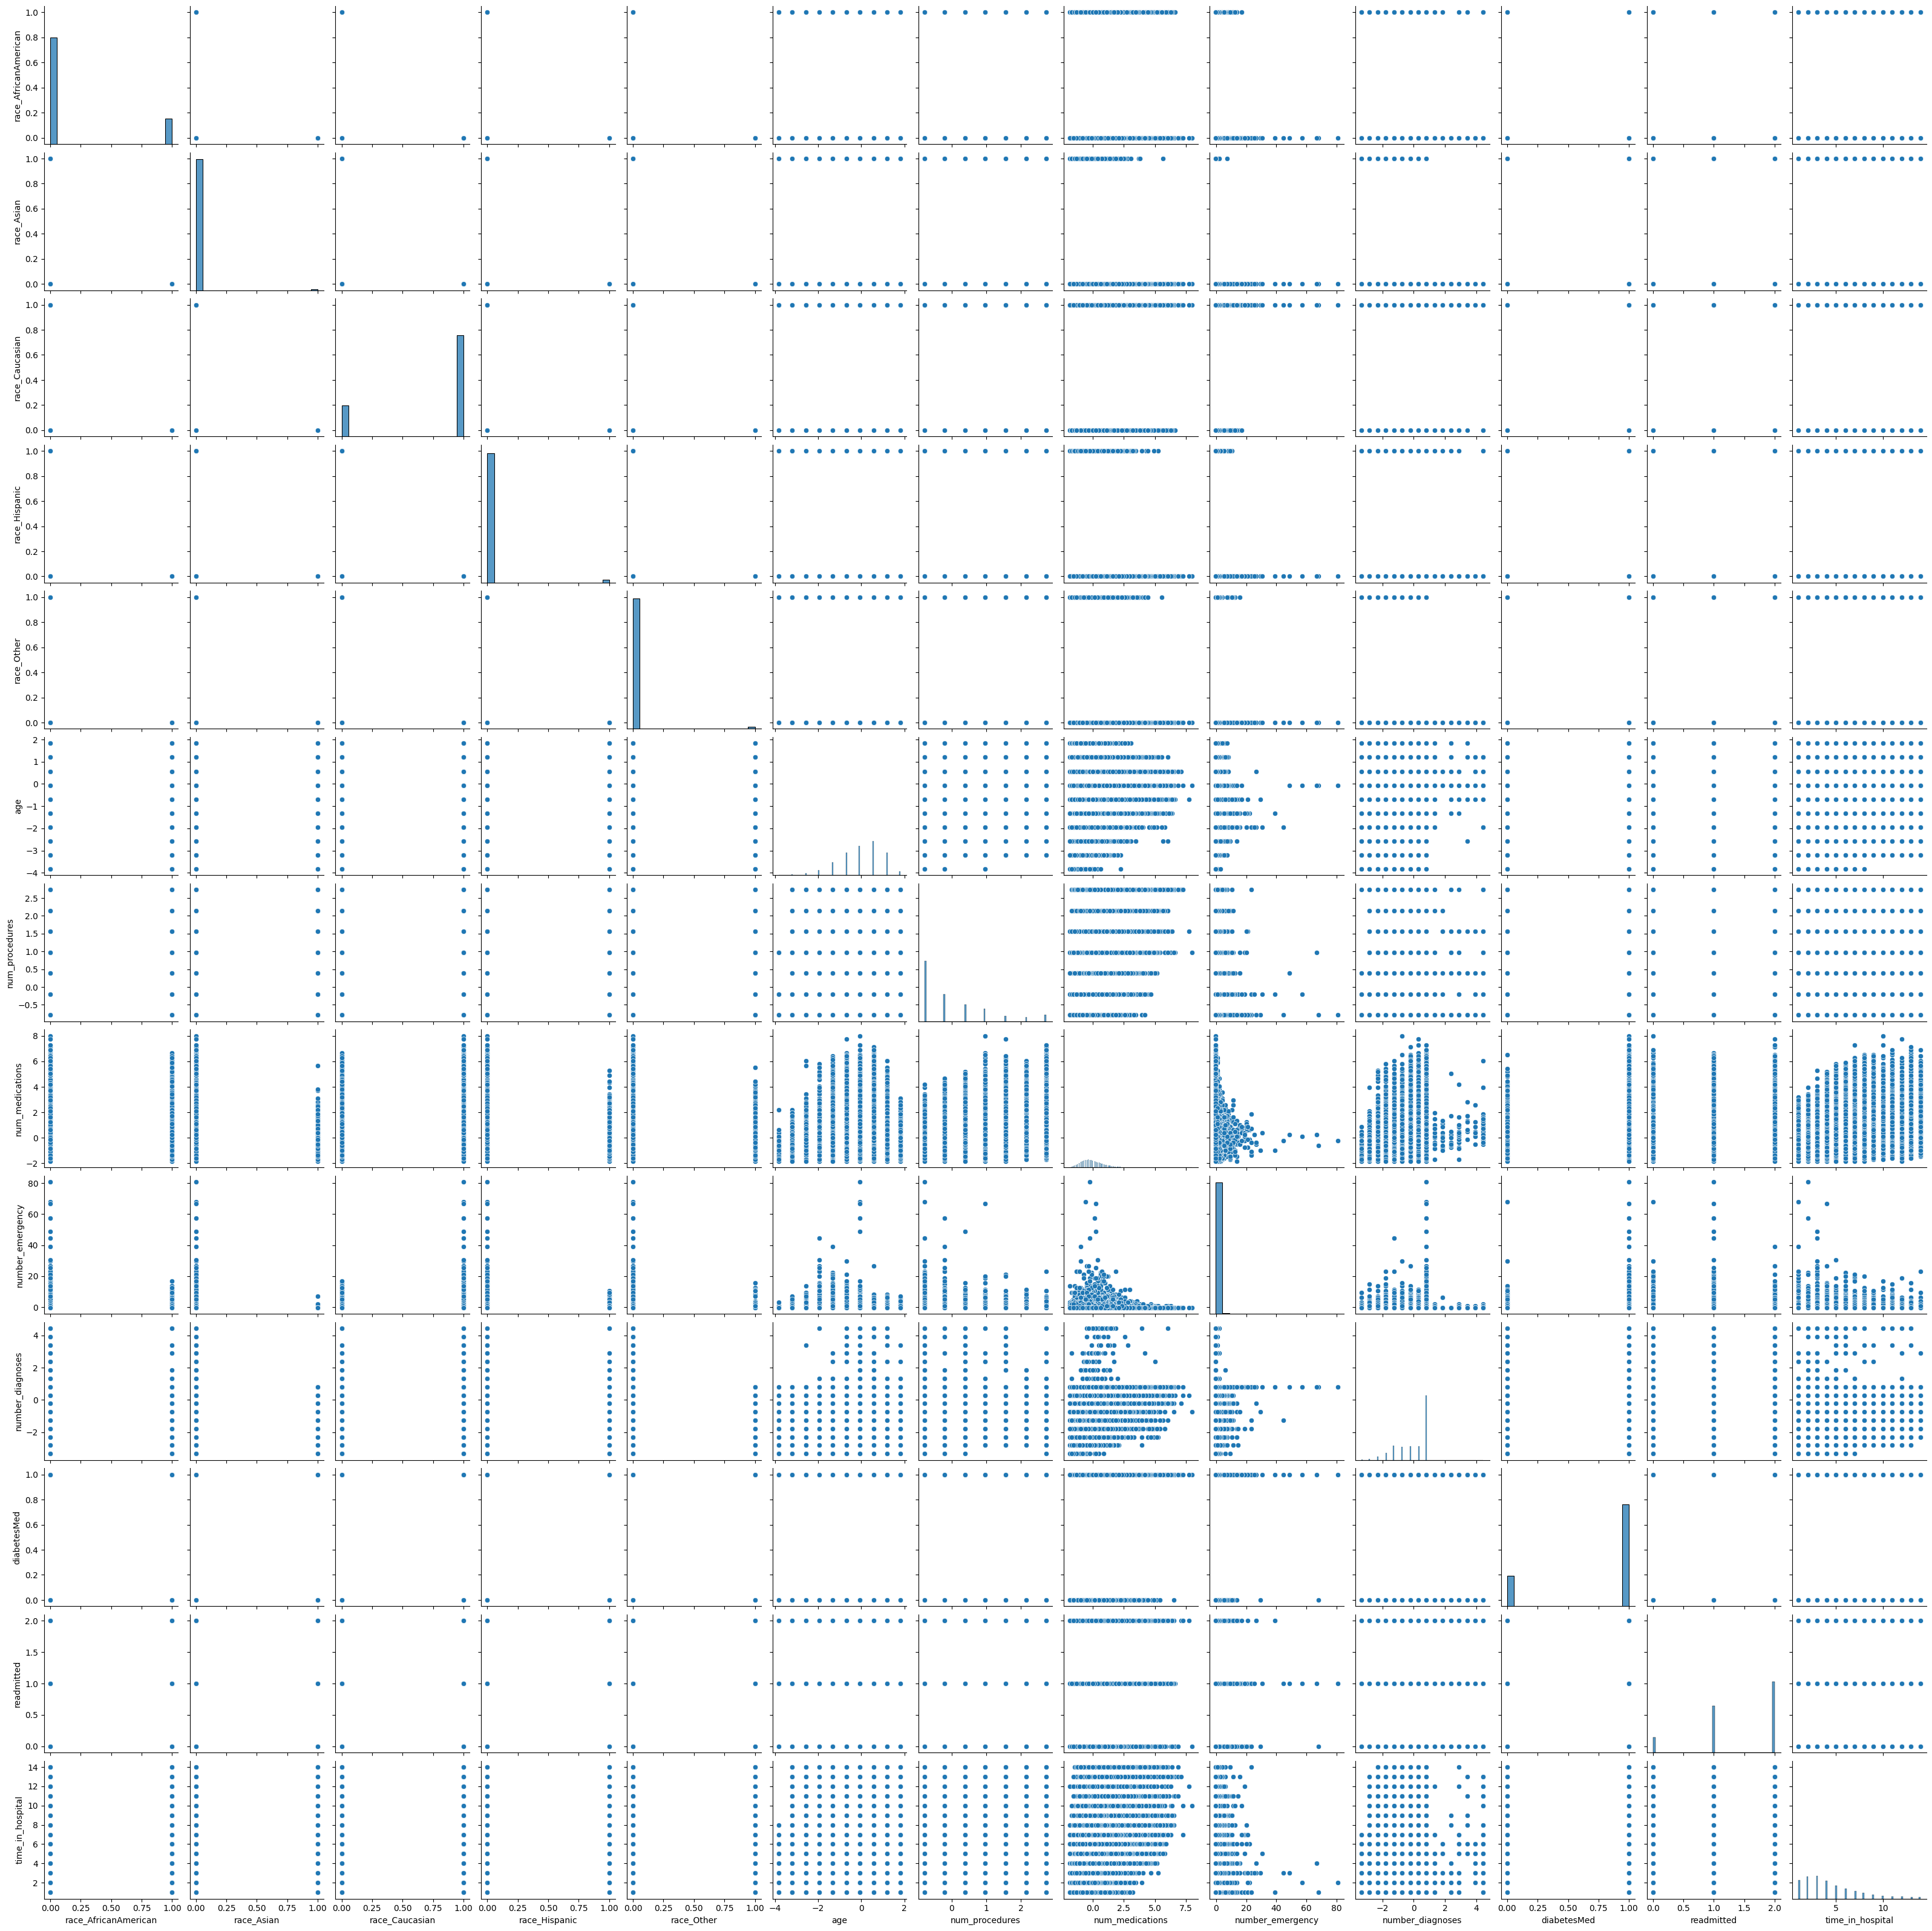

In [ ]:
sns.pairplot(data)

Observations from the pair plot

1.   Although they didn't show high correlation in the heatmap, num emergencies and num medications show a fairly distinct shape on their scatter plot. We can see everyone with a high number of emergencies wasn't on that much medication, but maybe this is a function of sample size.
2.   Num medications and age also have a distinct graph shape despite having low correlation on our heatmap.
3.   Number procedures vs. time in hospital is so perfectly square shaped its actually strikes me as odd
4.   Our data points for number of procedures are skewed heavily towards the highest value in range, that being 6.
5.   Caucasians are vastly over represented in the data set. They outnumber the other races combined by at least 3 to 1.

Datatype of the gender column in the dataframe indicates that there were still values not accounted for. We can drop these rows.

In [ ]:
data = data.dropna()
print(data.isna().sum())

race_AfricanAmerican    0
race_Asian              0
race_Caucasian          0
race_Hispanic           0
race_Other              0
gender                  0
age                     0
num_procedures          0
num_medications         0
number_emergency        0
number_diagnoses        0
diabetesMed             0
readmitted              0
time_in_hospital        0
dtype: int64


In [ ]:
# Find column elements that are neither 0 nor 1
data['gender'].unique()

array([0, 1, 'Unknown/Invalid'], dtype=object)

In [ ]:
# Drop rows that contain extraneous element & convert column to numerical
filter = data['gender'] == 'Unknown/Invalid'
data = data[~filter]
data['gender'] = pd.to_numeric(data['gender'])

# Verify dtype for dataframe
data.dtypes

race_AfricanAmerican      UInt8
race_Asian                UInt8
race_Caucasian            UInt8
race_Hispanic             UInt8
race_Other                UInt8
gender                    int64
age                     Float64
num_procedures          Float64
num_medications         Float64
number_emergency        Float64
number_diagnoses        Float64
diabetesMed               Int64
readmitted                Int64
time_in_hospital          Int64
dtype: object

In [ ]:
print(data['gender'].unique())
data.dtypes

[0 1]


race_AfricanAmerican      UInt8
race_Asian                UInt8
race_Caucasian            UInt8
race_Hispanic             UInt8
race_Other                UInt8
gender                    int64
age                     Float64
num_procedures          Float64
num_medications         Float64
number_emergency        Float64
number_diagnoses        Float64
diabetesMed               Int64
readmitted                Int64
time_in_hospital          Int64
dtype: object

In [ ]:
data.shape

(99492, 14)

In [ ]:
# shuffle data and split train test with seed
seed = 1
temp_df = data.sample(frac=1, random_state=seed)
train, test = np.split(temp_df, [int(np.round(temp_df.shape[0] * 0.8))])
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

In [ ]:
print(X_train.shape)
print(y_train.shape)

(79594, 13)
(79594,)


# Data Verification

Ensure our data follows the expected distributions and values.

### Datatype validation

race_AfricanAmerican
ShapiroResult(statistic=0.48200178146362305, pvalue=0.0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


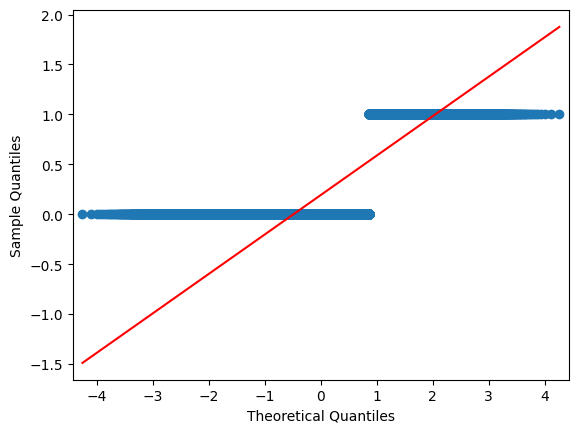

race_Asian
ShapiroResult(statistic=0.05123013257980347, pvalue=0.0)


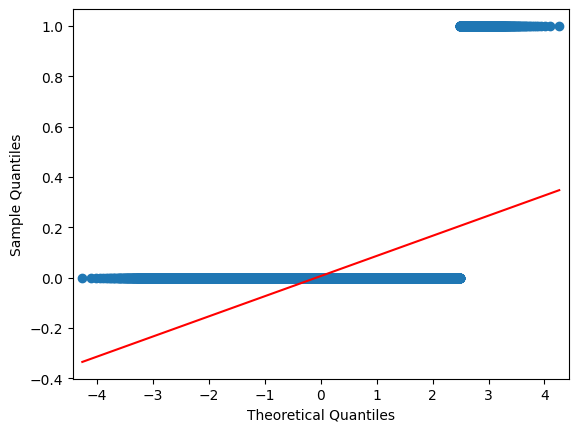

race_Caucasian
ShapiroResult(statistic=0.5253992080688477, pvalue=0.0)


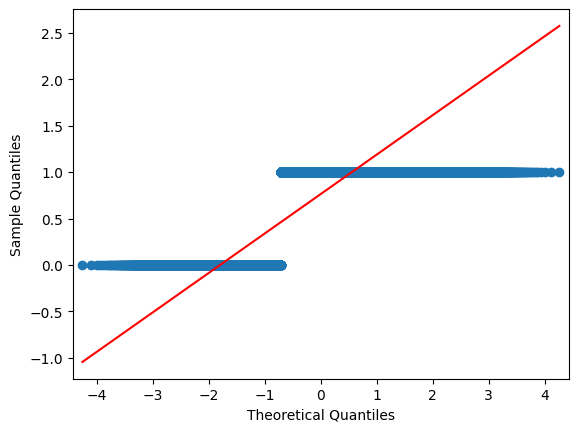

race_Hispanic
ShapiroResult(statistic=0.12162750959396362, pvalue=0.0)


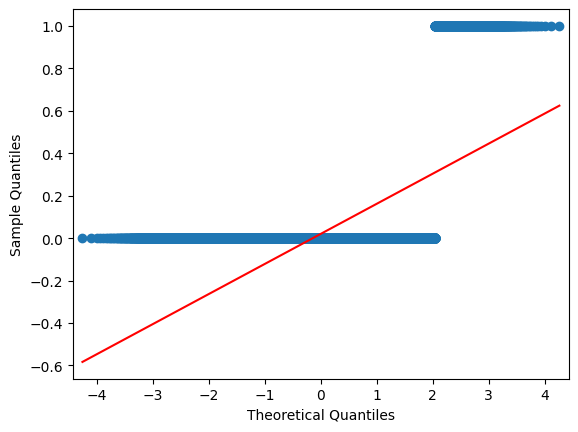

race_Other
ShapiroResult(statistic=0.09766680002212524, pvalue=0.0)


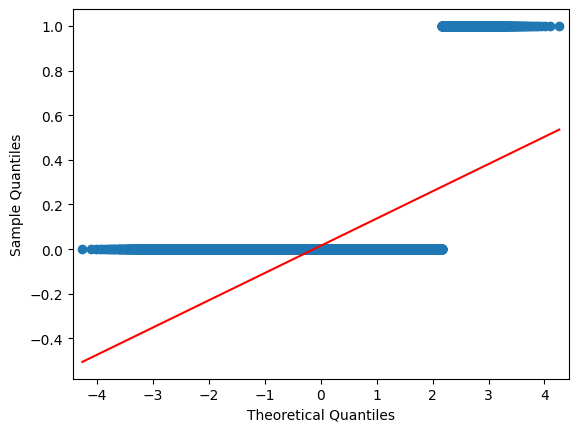

gender
ShapiroResult(statistic=0.6352283358573914, pvalue=0.0)


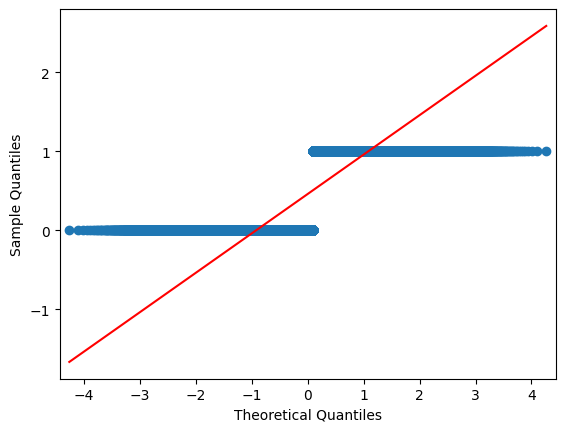

age
ShapiroResult(statistic=0.9394146800041199, pvalue=0.0)


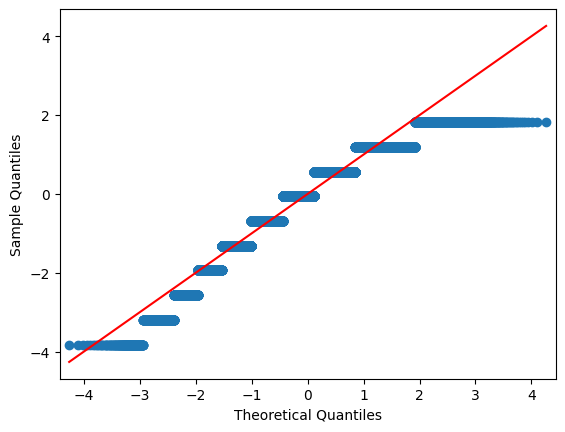

num_procedures
ShapiroResult(statistic=0.775197446346283, pvalue=0.0)


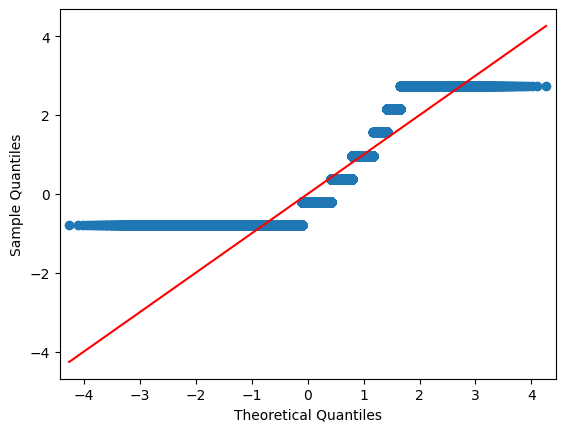

num_medications
ShapiroResult(statistic=0.9248144030570984, pvalue=0.0)


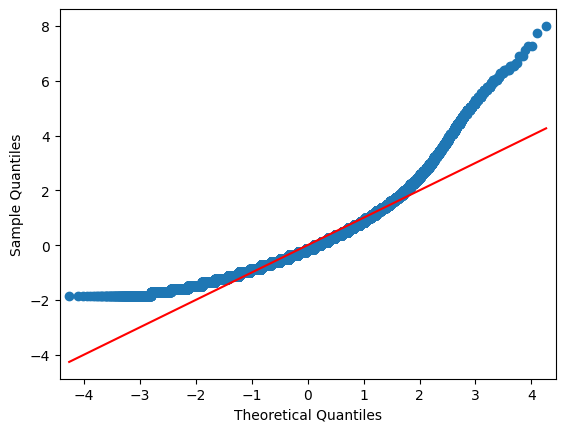

number_emergency
ShapiroResult(statistic=0.19951218366622925, pvalue=0.0)


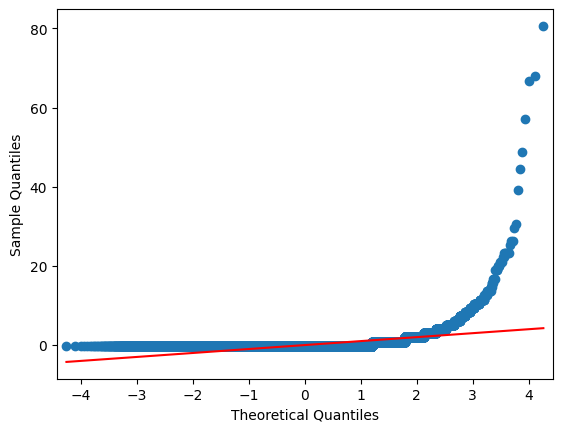

number_diagnoses
ShapiroResult(statistic=0.8009591698646545, pvalue=0.0)


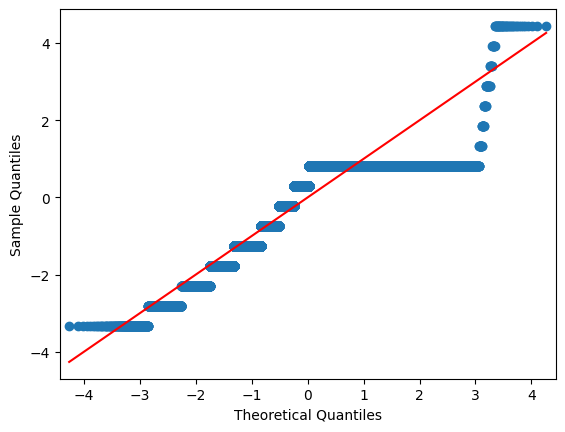

diabetesMed
ShapiroResult(statistic=0.5218844413757324, pvalue=0.0)


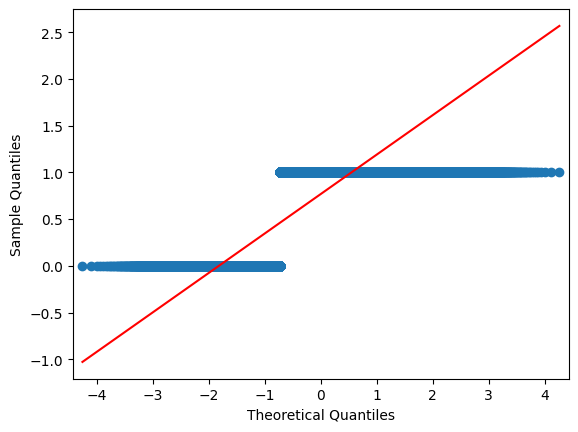

readmitted
ShapiroResult(statistic=0.7380174994468689, pvalue=0.0)


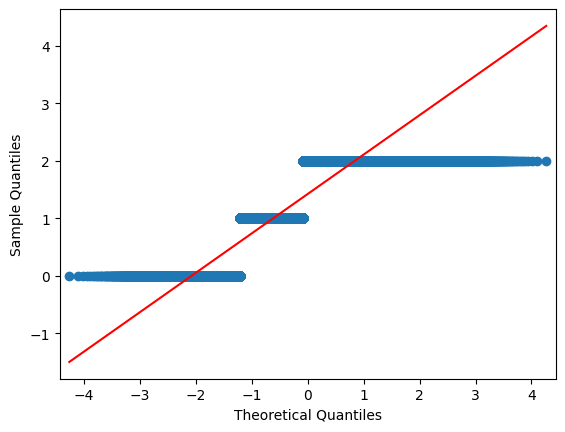

time_in_hospital
ShapiroResult(statistic=0.8868542909622192, pvalue=0.0)


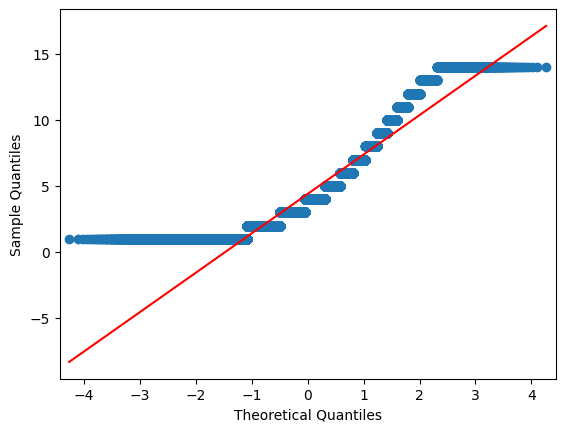

In [ ]:
# Use QQ-plot & Shapiro-Wilkes test for normality
for col in data.columns:
    print(col)
    print(shapiro(data[col]))
    qqplot(data[col], line='s')
    plt.show()


While it is expected that labels such as gender and race aren't normally distributed, we see from the QQ plots & the resulting p-values that our normalized and standardized columns do not follow the normal distribution very well, indicating that we may need to revisit our methods of normalizatiion & standardization. However, they do roughly follow a normal distribution.

# Milestone 3: Training our First Model

**Model Evaluation**  
Since we are attempting to predict days in hospital, which is an int, we decided to start with linear regression. When we evaluated our model's performance, even though the Train and Test were relatively the same, the model accuracy wasn't very good. To see if this was overfitting or underfitting, we tried using polynomial regression and saw that even though a degree of 2 is marginally better, the results are much the same. Therefore, it can be concluded that the current structure and data aren't well suited to the task. For future improvements, we can try to expand our dataset (such as readd dropped columns), or perhaps use bagging, where we build models of different polynomial degrees or data and take the mean of their predictions.

**Future Models**  
The first future model we plan on trying is to use a classic ANN/DNN since the output only ranges between 1-14 (14 classes), which is relatively narrow. Doing so will allow us to make our model much more complex with many more different combinations of layer sizes, depth, activation functions, and more.  
Our second future model plan is to use another regression model, likely polynomial or ridge regression. Even though we used polynomial regression to test how our linear regressor was working, there is much to expand upon with an improved dataset. However, since it is very similar to linear regression and what we have done so far, we may also try another form of regression such as ridge or lasso.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#basic linear regression
reg = LinearRegression()
regmodel = reg.fit(X_train, y_train)
yhat_train = reg.predict(X_train)
yhat_test = reg.predict(X_test)

In [ ]:
#Evalute our train vs test error for the linear model
print("Train MSE: ", mean_squared_error(y_train, yhat_train))
print("Train Standard Deviation: ", np.std(y_train - yhat_train))
print("Test MSE: ", mean_squared_error(y_test, yhat_test))
print("Test Standard Deviation: ", np.std(y_test - yhat_test))

Train MSE:  6.788051615805185
Train Standard Deviation:  2.60538895666701
Test MSE:  6.859473380135014
Test Standard Deviation:  2.618915481159026


In [ ]:
#Visualize our predictions
print(yhat_train[:5])
print(yhat_test[:5])

[2.90112305 5.21185303 3.91125488 4.87207031 3.69281006]
[4.35095215 3.47900391 3.59417725 5.74200439 3.67156982]


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
#can expanding features with Polynomials help?
for deg in range(5):
  poly_features = PolynomialFeatures(degree=deg)
  X_train_poly = poly_features.fit_transform(X_train)
  X_test_poly = poly_features.fit_transform(X_test)
  reg = LinearRegression()
  regmodel = reg.fit(X_train_poly, y_train)
  yhat_train = reg.predict(X_train_poly)
  yhat_test = reg.predict(X_test_poly)
  print("Degree: ", deg)
  print("Train: ", mean_squared_error(y_train, yhat_train))
  print("Test: ", mean_squared_error(y_test, yhat_test))

Degree:  0
Train:  8.919998445493041
Test:  8.929815509943827
Degree:  1
Train:  6.789047163090017
Test:  6.859988012533353
Degree:  2
Train:  6.592532350976919
Test:  6.663234989043572
Degree:  3
Train:  6.509905460091417
Test:  6.719595009263346
Degree:  4
Train:  6.42511935672439
Test:  757426.7446855529


#Milestone 4: Second Model



In [ ]:
print(X_train.shape)
print(y_train.unique())

(79594, 13)
<IntegerArray>
[2, 14, 6, 4, 1, 3, 10, 8, 5, 7, 9, 13, 12, 11]
Length: 14, dtype: Int64


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD



model = Sequential();

model.add(keras.Input(shape=(13,)))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="relu"))
model.add(Dense(14, activation="softmax"))

optimizer = SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["acc"])

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_train.dtypes)

(79594, 13)
(79594,)
Int64


In [ ]:
#history = model.fit(X_train.astype('float32'), y_train.astype('float32'), validation_split=0.2, batch_size = 10, epochs = 20, verbose = 1)
#this was very bad

In [ ]:
model2 = Sequential()
model2.add(Dense(40, input_dim=13, activation='linear'))  # First hidden layer
model2.add(Dense(40, activation='linear'))  # Second hidden layer
model2.add(Dense(40, activation='linear'))
model2.add(Dense(1))  # Output layer for regression

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model2.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
history2 = model2.fit(X_train.astype(float), y_train.astype(float), epochs=60, batch_size=50, verbose=0)

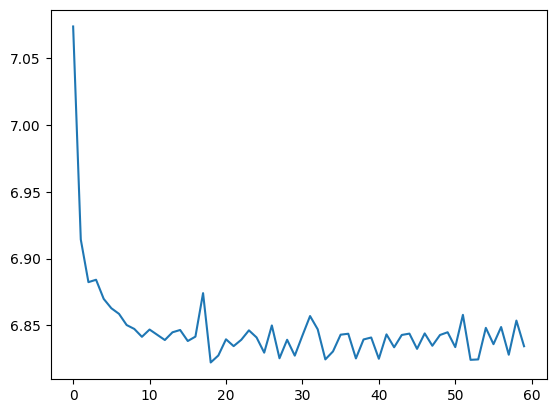

In [ ]:
plt.plot(history2.history['loss'])

In [ ]:
pred = model2.predict(X_test.astype(float))
print(pred.shape)

622/622 [==============================] - 1s 1ms/step
(19898, 1)


In [ ]:
mse = np.mean(np.square(pred.flatten() - y_test))

In [ ]:
mse

6.979234001997022

In [ ]:
ytr_ohe = pd.get_dummies(y_train)
ytes_ohe = pd.get_dummies(y_test)
print(ytr_ohe)


        1   2   3   4   5   6   7   8   9   10  11  12  13  14
80278    0   1   0   0   0   0   0   0   0   0   0   0   0   0
24566    0   0   0   0   0   0   0   0   0   0   0   0   0   1
14905    0   0   0   0   0   1   0   0   0   0   0   0   0   0
58934    0   0   0   1   0   0   0   0   0   0   0   0   0   0
21081    0   0   0   0   0   1   0   0   0   0   0   0   0   0
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
60466    0   0   0   0   1   0   0   0   0   0   0   0   0   0
62413    0   0   1   0   0   0   0   0   0   0   0   0   0   0
80637    0   0   0   1   0   0   0   0   0   0   0   0   0   0
100690   0   0   1   0   0   0   0   0   0   0   0   0   0   0
48411    0   0   0   0   0   0   1   0   0   0   0   0   0   0

[79594 rows x 14 columns]


In [ ]:
model3 = Sequential()
model3.add(Dense(40, input_dim=13, activation='linear'))  # First hidden layer
model3.add(Dense(40, activation='linear'))  # Second hidden layer
model3.add(Dense(40, activation='sigmoid'))
model3.add(Dense(14))  # Output layer for regression

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history3 = model3.fit(X_train.astype(float), ytr_ohe, epochs=60, batch_size=50, verbose=0)

In [ ]:
model5 = Sequential();

model5.add(keras.Input(shape=(13,)))
model5.add(Dense(40, activation="relu"))
model5.add(Dense(40, activation="relu"))
model5.add(Dense(40, activation="relu"))
model5.add(Dense(14, activation="sigmoid"))

optimizer = SGD(learning_rate=0.1)
model5.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['acc'])
history4 = model5.fit(X_train.astype(float), ytr_ohe, epochs=60, batch_size=50, verbose=0)

In [ ]:
# we could see using verbose this got to 22% accuracy
# Model2 was off by 2.6 on average, where as this one guesses right 22% of the time.
# Going to try going back to a regression model while dropping low correlation columns.

In [ ]:
# Age, num procedures, num diagnoses, and num medications have solid correlation
X_train_dropped = X_train.drop(['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender',
                                'number_emergency', 'diabetesMed', 'readmitted'], axis=1)
print(X_train_dropped)

             age  num_procedures  num_medications  number_diagnoses
80278   1.194503       -0.786858        -0.865372         -1.266432
24566  -1.314344       -0.199903         0.858819          0.810353
14905   0.567291       -0.199903        -0.619059          0.810353
58934   1.194503       -0.786858        -0.003277          -0.22804
21081  -1.941555       -0.199903        -0.126433          -0.22804
...          ...             ...              ...               ...
60466   -0.05992       -0.199903        -0.372746          0.810353
62413   -0.05992       -0.786858         0.366193          0.810353
80637  -1.314344       -0.786858         0.366193          -0.22804
100690 -1.314344       -0.786858        -0.126433         -0.747236
48411  -0.687132        2.147917         3.321949          0.810353

[79594 rows x 4 columns]


In [ ]:
model6 = Sequential()
model6.add(Dense(40, input_dim=4, activation='linear'))  # First hidden layer
model6.add(Dense(40, activation='linear'))  # Second hidden layer
model6.add(Dense(40, activation='linear'))
model6.add(Dense(1))  # Output layer for regression

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model6.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
history6 = model6.fit(X_train_dropped.astype('float'), y_train.astype('float'), epochs = 60, batch_size=50, verbose=0)

In [ ]:
# no noteworthy improvement. Lets try the dropped dataset for a categorical classification model.

In [ ]:
model7 = Sequential();

model7.add(keras.Input(shape=(4,)))
model7.add(Dense(40, activation="relu"))
model7.add(Dense(40, activation="relu"))
model7.add(Dense(40, activation="relu"))
model7.add(Dense(14, activation="sigmoid"))

optimizer = SGD(learning_rate=0.1)
model7.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['acc'])
history7 = model7.fit(X_train_dropped.astype(float), ytr_ohe, epochs=60, batch_size=50, verbose=0)

In [ ]:
# taking some metrics to visualize outcome and get graph
X_test_dropped = X_test.drop(['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender',
                                'number_emergency', 'diabetesMed', 'readmitted'], axis=1)
pred6 = model6.predict(X_test_dropped.astype('float'))
mean_error = np.mean(np.absolute(pred6.flatten() - y_test))
mse = np.mean(np.square(pred6.flatten() - y_test))
biggest_error = np.max(np.absolute(pred6.flatten() - y_test))

622/622 [==============================] - 1s 1ms/step


2.0099438772164153
6.912105627080606
11.898611068725586
[0.00000000e+00 1.00005026e+00 2.00010052e+00 ... 1.98959999e+04
 1.98969999e+04 1.98980000e+04]


<Axes: xlabel='error', ylabel='index in y_test'>

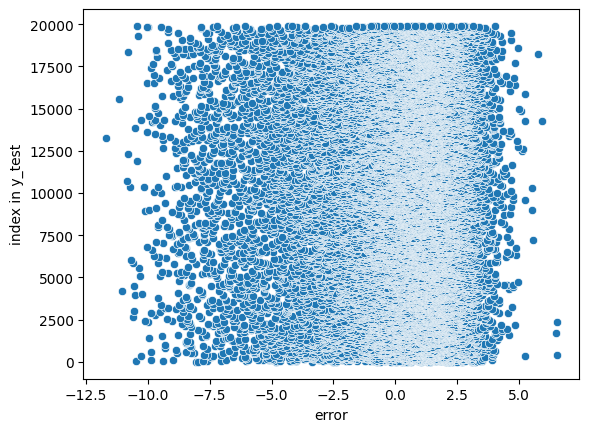

In [ ]:
print(mean_error)
print(mse)
print(biggest_error)
y_vals = np.linspace(0, y_test.shape[0], y_test.shape[0])
error = pred.flatten() - y_test
print(y_vals)
graphDF = {'error': error, 'index in y_test': y_vals}
sns.scatterplot(graphDF, x='error', y='index in y_test')

<Axes: xlabel='error', ylabel='index in y_test'>

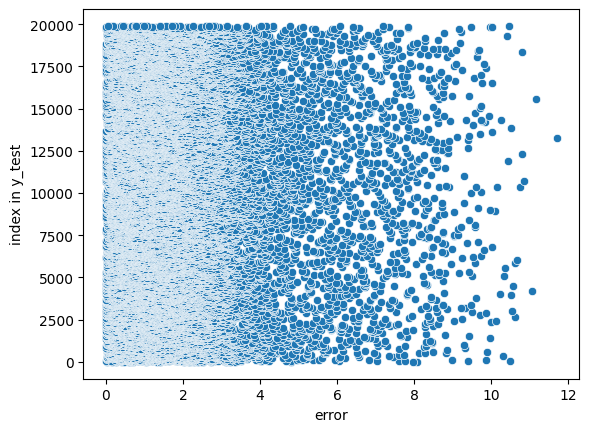

In [ ]:
#or with absolute value of the error
error = np.absolute(pred.flatten() - y_test)
graphDF = {'error': error, 'index in y_test': y_vals}
sns.scatterplot(graphDF, x='error', y='index in y_test')